In [1]:
import math
import random
# import minigrid
import numpy as np
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from array2gif import write_gif
# from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper


import gym_examples
from models import *
from utils import *

plt.ioff()


pygame 2.1.0 (SDL 2.0.16, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
num_skills = 4
# skill_eps_len = 10  # 90 10
# skill_eps_count = 10
num_episodes = 1000  # 600
# discount = 0.99
# final_step_discount = 0.99
lr_pred = 1e-4
# lr_reg = 1e-4
lr_policy = 1e-4
# lr_extractor = 1e-4
BATCH_SIZE = 32 # 64  # 128
GAMMA = 0.99
# epsilon: linear decay
EPS_START = 0.9
EPS_MIN = 0.05
EPS_END = 0
# EPS_DECAY = 50000
TAU = 0.005
# features_dim = 32 # 128
hid_dim = 32
q_memory = ReplayMemory(1000)
predictor_memory = MemoryDataset(96) # 300-600
# termination:length > 5
terminate_prob = 0.05

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
# env = gym_examples.OneHot(env)
env = gym_examples.AgentLocation(env)
# env = gym_examples.FullFrame(env)

n_actions = env.action_space.n
obs_dim = env.observation_space.shape[-1]
# obs, info = env.reset()
print(obs_dim)

2


/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(


In [4]:
predictor_net = Head(obs_dim * 2, num_skills, hid_dim=hid_dim, if_prob=False).to(device)

policy_net = Head(obs_dim, n_actions*num_skills, hid_dim=hid_dim,).to(device)
target_net = Head(obs_dim, n_actions*num_skills, hid_dim=hid_dim,).to(device)
target_net.eval()
target_net.load_state_dict(policy_net.state_dict())

pred_optimizer = optim.AdamW(predictor_net.parameters(), lr_pred)
policy_optimizer = optim.AdamW(policy_net.parameters(), lr_policy)

In [5]:
it = 0
def select_action(state, skill, eps_done):
    global it
    eps_threshold = epsilon(EPS_START, EPS_END, eps_done, EPS_MIN)
    if it > 5 and random.random() < terminate_prob:
        it = 0
        return None
    elif random.random() > eps_threshold:
        it += 1
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            q_values = policy_net(state).reshape((-1, n_actions, num_skills))[:,:, skill]
            return q_values.max(1).indices.view(-1, 1)
    else:
        it += 1
        return torch.tensor([[env.action_space.sample()]], device=device,) # dtype=torch.long

In [6]:
def compute_td_error():
    if len(q_memory) < BATCH_SIZE:
        return
    transitions = q_memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
    )
    state_batch =  torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    skill_batch = torch.cat(batch.skill)
    state_action_values = policy_net(state_batch).reshape((-1, n_actions, num_skills))[torch.arange(BATCH_SIZE), action_batch.squeeze().int()] # [B,N_Skills]

    next_state_values = torch.zeros((BATCH_SIZE, num_skills), device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).reshape(-1, n_actions, num_skills)
            .max(1)
            .values
        )
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # print(reward_batch.shape)
    # print(next_state_values.shape)
    # print(state_action_values.shape)
    # print(reward_batch)
    # print(next_state_values)
    # print(state_action_values)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    td_error = criterion(
        state_action_values, expected_state_action_values
    )
    # print(next_state_values * GAMMA, reward_batch.unsqueeze(1))
    # print(td_error)

    # Optimize the model
    policy_optimizer.zero_grad()
    td_error.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    policy_optimizer.step()

    return td_error

In [7]:
def plot_skill_for_state(init_state, fname, size=10):
    map = np.zeros((size, size))
    init_state = torch.tensor(
            init_state, dtype=torch.float32, device=device
        ).unsqueeze(0)
    for i in range(size):
        for j in range(size):
            state = torch.tensor(
            [i, j], dtype=torch.float32, device=device
        ).unsqueeze(0)
            init_term = torch.cat((init_state, state), dim=1)
            map[i][j] = predictor_net(init_term).argmax(dim=1).squeeze().item()/num_skills
    plt.imshow(map, cmap='rainbow')
    plt.savefig(fname)

In [8]:
def plot_trajectories(fname, options=None):
    num_eval_episodes = 1 if options else 4
    plt.figure()
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    for skill in range(num_skills):
        for eps in range(num_eval_episodes):
            obs, _ = env.reset(options=options)
            trajectory = [obs]
            for t in range(20):
                obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(
                    0
                )
                action = (
                    target_net(obs)
                    .reshape(-1, n_actions, num_skills)[:, :, skill]
                    .max(1)
                    .indices.view(1, 1)
                )

                obs, reward, terminated, truncated, _ = env.step(action.item())
                trajectory.append(obs+np.random.uniform(-0.1, 0.1, 2))

                done = terminated | truncated

                if done or action is None:
                    break
            trajectory = [*zip(*trajectory)]
            # flip upside down
            plt.plot(trajectory[1], trajectory[0], '-o', c=cm.rainbow(skill/num_skills), label=skill)
    # plt.legend()
    if options:
        plt.plot(options[0], options[1], '*', c='black')
    plt.plot()
    plt.grid()
    plt.savefig(fname)
    plt.close()

In [9]:
called_time = 0
def update_pred():
    global called_time
    train_dataset, valid_dataset = torch.utils.data.random_split(predictor_memory, [0.8, 0.2])
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
    stopper = EarlyStopper(patience=2000, min_delta=-0.001, if_save=True)
    training_losses = []
    valid_losses = []

    for epoch in tqdm(range(5000)):
        num_batch = 0
        train_loss_sum = 0
        predictor_net.train()
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = predictor_net(X)
            # print(pred.shape, y.shape)
            loss = torch.nn.functional.cross_entropy(pred, y)
            num_batch += 1
            train_loss_sum += loss

            # Backpropagation
            loss.backward()
            pred_optimizer.step()
            pred_optimizer.zero_grad()
        training_losses.append(train_loss_sum/num_batch)
        
        predictor_net.eval()
        valid_loss_sum = 0
        num_batch = 0
        for batch, (X, y) in enumerate(valid_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = predictor_net(X)
            loss = torch.nn.functional.cross_entropy(pred, y)
            num_batch += 1
            valid_loss_sum += loss

        valid_loss = valid_loss_sum/num_batch
        valid_losses.append(valid_loss)

        if stopper.early_stop(valid_loss, state_dict=predictor_net.state_dict(), path="vic_pred_temp.dict",):
            predictor_net.load_state_dict(torch.load("vic_pred_temp.dict"))
            break
    plot_skill_for_state([4,4], fname=f"eval/vic_pred_map_center_{called_time}.png")
    plot_skill_for_state([7,7], fname=f"eval/vic_pred_map_corner_{called_time}.png")
    plt.figure()
    plt.plot([*range(len(training_losses))], [i.item() for i in training_losses], label='train')
    plt.plot([*range(len(valid_losses))], [i.item() for i in valid_losses], label='valid')
    plt.legend()
    plt.savefig(f"eval/vic_pred_loss_{called_time}.png")
    plt.close()
    called_time += 1
    predictor_net.train()
    return valid_loss

    # return loss


Episode 31 predictor_memory length: 32


  1%|          | 45/5000 [00:00<00:11, 449.54it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1174.99it/s]


Episode 31 done. [tensor(0.9125, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9075, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9637, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9083, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9378, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9263, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9328, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9194, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.8374, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.1130, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9179, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.8251, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.8514, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9360, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.0214, device='cuda:0', grad_fn=<SmoothL1LossBackw

100%|██████████| 1000/1000 [00:00<00:00, 1542.78it/s]


Episode 63 done. [tensor(0.7261, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.8736, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.7712, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.7913, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.6683, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.7646, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.7201, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.7051, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.7427, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.6964, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.7100, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.6608, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.5943, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.6173, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.6056, device='cuda:0', grad_fn=<SmoothL1LossBackw

100%|██████████| 1000/1000 [00:00<00:00, 1492.43it/s]


Episode 95 done. [tensor(1.1585, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.1674, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.1253, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.1374, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.0836, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.1119, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.1206, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.0423, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9812, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9971, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9249, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.8364, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.9499, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.8642, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(0.8157, device='cuda:0', grad_fn=<SmoothL1LossBackw

100%|██████████| 1000/1000 [00:00<00:00, 1542.47it/s]


Episode 127 done. [tensor(2.0974, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.6523, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.8124, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.4412, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.6248, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.8795, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.9481, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.6728, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7648, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7091, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.5522, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.6151, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.6289, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.5572, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.8577, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1539.19it/s]


Episode 159 done. [tensor(2.8370, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.6922, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.9715, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.2249, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.2211, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.3505, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.3632, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.1721, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.0389, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.1311, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7291, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.4943, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.1495, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.9799, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.2701, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1541.95it/s]


Episode 191 done. [tensor(1.6355, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7849, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7424, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.4248, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.1308, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.9596, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.6754, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7686, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.5564, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.8966, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.9637, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7942, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.9889, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.4626, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.4753, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1496.91it/s]


Episode 223 done. [tensor(2.4086, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.9237, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7135, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.8686, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7582, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.8017, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.8146, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.4417, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.2877, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.0569, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.0260, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7832, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7545, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.8625, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7670, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1546.40it/s]


Episode 255 done. [tensor(2.2686, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.7236, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.1790, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.8699, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(1.7404, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.5443, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.7362, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.7268, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.3832, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.6737, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.1585, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.4697, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.2618, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.7284, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(2.4237, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1544.67it/s]


Episode 287 done. [tensor(9.4790, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.8743, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.4513, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.1170, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.1492, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.1365, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.4916, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.5400, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.3276, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.2761, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.3258, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.2577, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.7611, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.1938, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.6660, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1488.67it/s]


Episode 319 done. [tensor(9.1796, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.3301, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.7328, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.5626, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.1310, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.1558, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.2191, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.9845, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.4774, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.2867, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.6278, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.7398, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.0529, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.5192, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.0672, device='cuda:0', grad_fn=<SmoothL1LossBa

100%|██████████| 1000/1000 [00:00<00:00, 1537.75it/s]


Episode 351 done. [tensor(6.0656, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.1674, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.0372, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.4197, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(4.9792, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.2041, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.6428, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.4577, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.5969, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.1325, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.6427, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.1682, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.2272, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.4309, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.4854, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1544.09it/s]


Episode 383 done. [tensor(3.6901, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.0368, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.7613, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.5229, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.9430, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(4.9174, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.2893, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.8914, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.7849, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(4.6130, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(4.5246, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.5321, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(4.4005, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.9447, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(3.9842, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1526.68it/s]


Episode 415 done. [tensor(3.4438, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.0627, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.2068, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.5658, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.0265, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.3304, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.5615, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.8813, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.4801, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.3965, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.3123, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.0790, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.3811, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.4585, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.4922, device='cuda:0', grad_fn=<SmoothL1LossBac

100%|██████████| 1000/1000 [00:00<00:00, 1509.30it/s]


Episode 447 done. [tensor(5.5358, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.0609, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.9234, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(4.9944, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.4828, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.4879, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(4.5041, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.2416, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.0972, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.2576, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.5301, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.2537, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.7192, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.4935, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.3323, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1538.25it/s]


Episode 479 done. [tensor(4.5130, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.0196, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.1167, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.6684, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.5205, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.6517, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.2048, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.7520, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.9618, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.9642, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.6086, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.1813, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.4275, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.8943, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.9665, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1532.29it/s]


Episode 511 done. [tensor(9.3389, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.9953, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.0159, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.2047, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.8415, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.9533, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.3419, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.2904, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.7685, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.0450, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.5518, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.1372, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.4197, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.0464, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.9948, device='cuda:0', grad_fn=<SmoothL1LossBac

100%|██████████| 1000/1000 [00:00<00:00, 1518.24it/s]


Episode 543 done. [tensor(7.2920, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.8861, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.1567, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.7820, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.2546, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.2516, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.2818, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.9746, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.3921, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.7772, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.1992, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.1686, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.9039, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.9695, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.7098, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1527.27it/s]


Episode 575 done. [tensor(5.7087, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.8867, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.1582, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.3148, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.7202, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.3575, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.2042, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.0879, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.6086, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.8419, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.5205, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.2698, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.1582, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.3348, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.7329, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1512.29it/s]


Episode 607 done. [tensor(6.2217, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.7792, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.8365, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(11.9831, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.4906, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.0670, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.4388, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.3256, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.8372, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.0492, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.4925, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.8023, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.0479, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.8326, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.2058, device='cuda:0', grad_fn=<SmoothL1LossB

100%|██████████| 1000/1000 [00:00<00:00, 1513.57it/s]


Episode 639 done. [tensor(10.1368, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.7260, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.6184, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.1693, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.1276, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.6509, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.4054, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.9012, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.3681, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.3690, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.8256, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.0273, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.5937, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.9087, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.9657, device='cuda:0', grad_fn=<SmoothL1Los

100%|██████████| 1000/1000 [00:00<00:00, 1522.54it/s]


Episode 671 done. [tensor(8.6153, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.0532, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(5.9765, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.1306, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.0048, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.2935, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.8068, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.5643, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.0162, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.1382, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.2726, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.6977, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.8737, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.6720, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.2231, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1526.73it/s]


Episode 703 done. [tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.3682, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.5626, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', g

100%|██████████| 1000/1000 [00:00<00:00, 1530.91it/s]


Episode 735 done. [tensor(7.8583, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.8403, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.4976, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.7162, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.6838, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.5316, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.8433, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.1582, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.3682, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.2556, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.5091, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.5155, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.3844, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.3285, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.4273, device='cuda:0', grad_fn=<SmoothL1LossBack

100%|██████████| 1000/1000 [00:00<00:00, 1522.24it/s]


Episode 767 done. [tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.4304, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(11.4806, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(16.0173, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(11.8298, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.4218, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.2422, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.0820, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.8617, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(11.8122, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), t

100%|██████████| 1000/1000 [00:00<00:00, 1526.09it/s]


Episode 799 done. [tensor(7.6553, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.9735, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(6.6508, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.3468, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.0156, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.5729, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.2545, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.9378, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.9937, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.2440, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.2945, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.1759, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.0629, device='cuda:0', grad_fn=<SmoothL1LossBackward0>

100%|██████████| 1000/1000 [00:00<00:00, 1522.18it/s]


Episode 831 done. [tensor(9.6124, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.1255, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.1573, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.7639, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.2261, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.9314, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.3876, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.3995, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.4468, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.1879, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.9141, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.2129, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.4652, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.6671, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(7.0486, device='cuda:0', grad_fn=<SmoothL1Loss

100%|██████████| 1000/1000 [00:00<00:00, 1515.18it/s]


Episode 863 done. [tensor(12.6222, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(14.2082, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(15.2180, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.7666, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(16.3048, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(15.0249, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(13.9091, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(i

100%|██████████| 1000/1000 [00:00<00:00, 1519.22it/s]


Episode 895 done. [tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(14.1949, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', gra

100%|██████████| 1000/1000 [00:00<00:00, 1463.07it/s]


Episode 927 done. [tensor(9.7666, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.5346, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.6755, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.4514, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.9518, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.7302, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.1757, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.1243, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.2598, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.1846, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.6179, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.7309, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.7581, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.3942, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.7707, device='cuda:0', grad_fn=<SmoothL1Lo

100%|██████████| 1000/1000 [00:00<00:00, 1526.76it/s]


Episode 959 done. [tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.7420, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(10.8133, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(12.4692, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda

100%|██████████| 1000/1000 [00:00<00:00, 1522.85it/s]


Episode 991 done. [tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(8.9381, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(9.8538, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(11.2026, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0', grad_fn=<SmoothL1LossBackward0>), tensor(inf, device='cuda:0

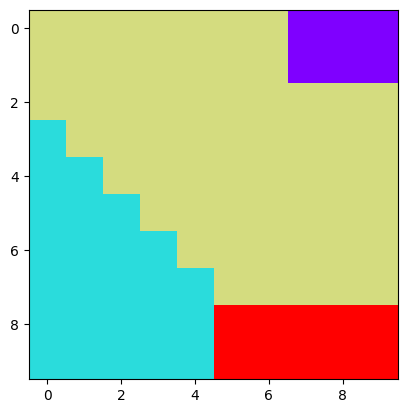

In [10]:
# td_error_list = []
reward_list = []
pred_loss_list = []
# reg_loss_list = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(
        0
    )
    skill = torch.tensor(
        [random.choice([*range(num_skills)])], device=device
    ).unsqueeze(
        0
    )  # [1, 1]

    secondary_memory = []
    action = None
    while action is None:
        action = select_action(state, skill.item(), i_episode)
    while action is not None:
        observation, _, terminated, truncated, _ = env.step(
            action.item()
        )  # ignore reward
        done = terminated or truncated
        next_state = torch.tensor(
            observation, dtype=torch.float32, device=device
        ).unsqueeze(0)

        if terminated:
            secondary_memory.append((state, action, None))
        else:
            secondary_memory.append((state, action, next_state))

        state = next_state
        action = select_action(state, skill.item(), i_episode)

        if done:
            break

    initial_state = secondary_memory[0][0]
    init_terminal = torch.cat((initial_state, state), dim=1)
    predictor_memory.add((init_terminal.squeeze(0), skill.squeeze()))
    

    if i_episode % 32 == 31:
        print(f"Episode {i_episode} predictor_memory length: {len(predictor_memory)}")
        pred_loss = update_pred()
        pred_loss_list.append(pred_loss)
        with torch.no_grad():
            for transition in q_memory.memory:
                # TODO: change this
                transition._replace(
                    reward = torch.log(torch.softmax(predictor_net(transition.init_terminal), dim=1))
                ) # bug # log instability?

    with torch.no_grad():
        reward = torch.log(torch.softmax(predictor_net(init_terminal), dim=1))
        # - torch.nn.functional.cross_entropy(predictor_net(init_terminal), skill.squeeze(0).to(device)).unsqueeze(0) 
        # - prev_regularizer_net(state_feature)[:, skill.item()]
        # print(reward)
        reward_list.append(reward)

    for s, a, ns in secondary_memory:
        q_memory.push(s, a, ns, skill, reward, init_terminal)

    # train 10 times
    # TODO: prioritized queue
    # td_error = None
    if i_episode % 32 == 31:
        
        td_errors = []
        for j in tqdm(range(1000)):
            td_error = compute_td_error()
            if td_error:
                td_errors.append(td_error)
        print(f"Episode {i_episode} done. {td_errors}")

        if td_errors:
            plt.figure()
            plt.plot([*range(len(td_errors))], [i.item() for i in td_errors], label='train')
            print(td_errors)
            plt.savefig(f"eval/vic_policy_train_{i_episode//32}.png")
            plt.close()
            target_net.load_state_dict(policy_net.state_dict())
            # td_error_list.append(td_error)
            plot_trajectories(f"eval/vic_policy_trac_1_{i_episode//32}.png", options=[4,4])
            plot_trajectories(f"eval/vic_policy_trac_2_{i_episode//32}.png", options=[7,7])
    # else:
    #     td_error_list.append(torch.tensor(0))

    if i_episode > 0 and not i_episode % 100:
        torch.save(
            target_net.state_dict(), "target_net_{}.dict".format(i_episode)
        )

print("Complete")

In [28]:
# for idx, r in enumerate(zip(*torch.cat(reward_list))):
#     print(r)
#     plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in r], label=idx)
# plt.show()

In [ ]:
assert(False)

AssertionError: 

In [ ]:
env = gym.make("gym_examples/GridWorld-v0", size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.AgentLocation(env)
env = gym.wrappers.RecordVideo(
    env,
    video_folder="eval",
    name_prefix="eval",
    episode_trigger=lambda x: True,
)
num_eval_episodes = 8
vis_map = np.zeros((10, 10))
final_map = np.zeros((10, 10))
skill = 3
for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()
    vis_map[obs[0]][obs[1]] = episode_num + 1
    initial_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    for t in range(100):
        obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(
            0
        )
        action = (
            target_net(obs)
            .reshape(-1, n_actions, num_skills)[:, :, skill]
            .max(1)
            .indices.view(1, 1)
        )
        # action = select_action(obs, 4, 100000)

        if action is not None:
            obs, reward, terminated, truncated, _ = env.step(action.item())
            vis_map[obs[0]][obs[1]] = episode_num + 1

        done = terminated | truncated

        if done or action is None:
            break
    final_map[obs[0]][obs[1]] = final_map[obs[0]][obs[1]] + 1
    obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(
            0
        )
    with torch.no_grad():
        init_terminal = torch.cat((initial_state, obs), dim=1)
        # NOTE: may need to change
        reward = -torch.nn.functional.cross_entropy(
            predictor_net(init_terminal), torch.tensor([7]).to(device)
        ).unsqueeze(0)
        print(reward)
    # if map is not None:
    #     map += (1+episode_num)*obs
    # else:
    #     map = (1+episode_num)*obs
# print(map.reshape((10, 10)))
print(vis_map)
print(final_map)
env.close()

# [0. 0. 0. 0. 7. 4. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [5. 0. 0. 0. 0. 0. 3. 0. 0. 8.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/Documents/rl_experiments/eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
env = gym.make("gym_examples/GridWorld-v0", size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.OneHot(env)
env = gym.wrappers.RecordVideo(
    env,
    video_folder="eval",
    name_prefix="eval",
    episode_trigger=lambda x: True,
)
num_eval_episodes = 8
vis_map = None

for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()

    for t in range(100):
        obs = torch.tensor(
            obs, dtype=torch.float32, device=device
        ).unsqueeze(0)
        action = (
            target_net(obs).reshape(-1, n_actions, num_skills)[:,:, episode_num]
            .max(1)
            .indices.view(1, 1)
        )
        # action = select_action(obs, 4, 100000)
        
        if action is not None:
            obs, reward, terminated, truncated, _ = env.step(action.item())
            
        done = terminated | truncated

        if done or action is None:
            break
    if vis_map is not None:
        vis_map += (1+episode_num)*obs
    else:
        vis_map = (1+episode_num)*obs
print(vis_map.reshape((10, 10)))

env.close()

# [0. 0. 0. 0. 7. 4. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [5. 0. 0. 0. 0. 0. 3. 0. 0. 8.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]



/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(
/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/Documents/rl_experiments/eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100 and 2x32)

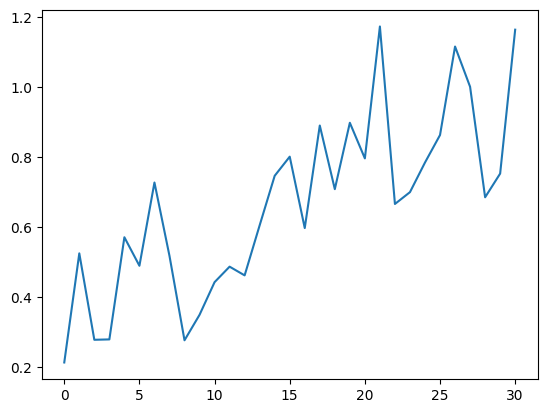

In [ ]:
plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in pred_loss_list])

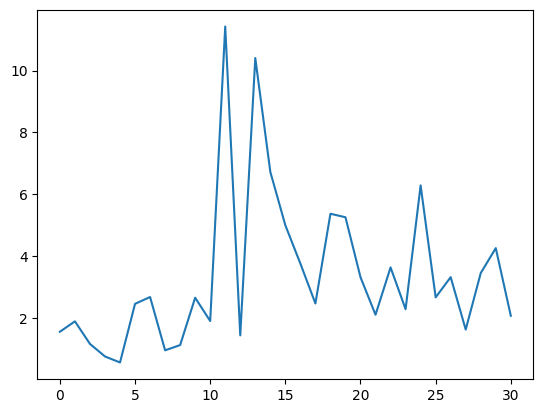

In [ ]:
plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in td_error_list])

In [ ]:
# obs, _ = env.reset()

# input = torch.cat((torch.tensor(obs, dtype=torch.float, device=device).unsqueeze(0).repeat(2, 1), torch.eye(2).to(device)),dim=1)
# state_skills = predictor_net(input)
# state_skill_map = torch.argmax(state_skills, 1).reshape((10, 10)) # skills preferred by states # untouched?
# state_skill_value = torch.max(state_skills, 1).values.reshape((10, 10))
# skill_state = torch.argmax(state_skills, 0) # states preferred by skills
# skill_state_value = torch.max(state_skills, 0).values
# skill_state_map = torch.zeros((10, 10))
# for idx, i in enumerate(skill_state):
#     r = int(i/10)
#     c = i%10
#     skill_state_map[r][c] = 1+idx
# skill_state_map

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x102 and 4x32)

tensor([[0., 0., 8., 0., 4., 0., 0., 0., 0., 0.],
        [6., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 5.],
        [0., 0., 0., 0., 0., 0., 0., 3., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 7.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
env = gym.make("gym_examples/GridWorld-v0", size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.OneHot(env)
env = gym.wrappers.RecordVideo(
    env,
    video_folder="eval",
    name_prefix="eval",
    episode_trigger=lambda x: True,
)
num_eval_episodes = 8
vis_map = None

for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()

    for t in range(100):
        obs = torch.tensor(
            obs, dtype=torch.float32, device=device
        ).unsqueeze(0)
        action = (
            target_net(obs).reshape(-1, n_actions, num_skills)[:,:, 0]
            .max(1)
            .indices.view(1, 1)
        )
        # action = select_action(obs, 4, 100000)
        
        if action is not None:
            obs, reward, terminated, truncated, _ = env.step(action.item())
            
        done = terminated | truncated

        if done or action is None:
            break
    if vis_map is not None:
        vis_map += obs
    else:
        vis_map = obs
print(vis_map.reshape((10, 10)))

env.close()


/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/Documents/rl_experiments/eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Moviepy - Building video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4.
Moviepy - Writing video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4
